In [302]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [303]:
df = pd.read_csv('../ufcScraper/ufc_fights_3yrs_from_7_8_23.csv')

In [304]:
df["date"] = pd.to_datetime(df["date"])
df.sort_values(by=['date'], ascending=False, inplace=True)
df = df.reset_index(drop=True)
fighter_names = pd.concat([df['fighter1'], df['fighter2']])

# # Create a mapping of unique fighter names to unique identifiers
unique_fighters = fighter_names.unique()
fighter_id_map = {fighter: idx for idx, fighter in enumerate(unique_fighters)}

# Map fighter names in 'fighter1' and 'fighter2' columns to their respective identifiers
df['fighter1_id'] = df['fighter1'].map(fighter_id_map)
df['fighter2_id'] = df['fighter2'].map(fighter_id_map)

# # Display the mapping of fighter names to their corresponding identifiers
# print("Fighter Name to ID Mapping:")
# for fighter, fighter_id in fighter_id_map.items():
#     print(f"{fighter}: {fighter_id}")

In [305]:
# Function to calculate past 3 fight results for each fighter at that time
def calculate_past3(row, df):
    fighter1 = row['fighter1']
    fighter2 = row['fighter2']
    
    # Get the index of the current row
    current_index = row.name
    
    # Filter the DataFrame for fights prior to the current row
    past_fights = df.iloc[current_index+1:]
    
    # Filter past fights for each fighter's past 3 fights
    past_fights_fighter1 = past_fights[((past_fights['fighter1'] == fighter1) | (past_fights['fighter2'] == fighter1))].head(3)
    past_fights_fighter2 = past_fights[((past_fights['fighter1'] == fighter2) | (past_fights['fighter2'] == fighter2))].head(3)
    
    # Calculate wins and losses for fighter1 regardless of their position
    fighter1_wins = (((past_fights_fighter1['fighter1'] == fighter1) & (past_fights_fighter1['result'] == 1)) |
                     ((past_fights_fighter1['fighter2'] == fighter1) & (past_fights_fighter1['result'] == 0))).sum()
    
    fighter1_losses = (((past_fights_fighter1['fighter1'] == fighter1) & (past_fights_fighter1['result'] == 0)) |
                       ((past_fights_fighter1['fighter2'] == fighter1) & (past_fights_fighter1['result'] == 1))).sum()
    
    # Calculate wins and losses for fighter2 regardless of their position
    fighter2_wins = (((past_fights_fighter2['fighter1'] == fighter2) & (past_fights_fighter2['result'] == 1)) |
                     ((past_fights_fighter2['fighter2'] == fighter2) & (past_fights_fighter2['result'] == 0))).sum()
    
    fighter2_losses = (((past_fights_fighter2['fighter1'] == fighter2) & (past_fights_fighter2['result'] == 0)) |
                       ((past_fights_fighter2['fighter2'] == fighter2) & (past_fights_fighter2['result'] == 1))).sum()
    
    # Return sum of wins and losses for each fighter
    return pd.Series({
        'fighter1_past3': fighter1_wins - fighter1_losses,
        'fighter2_past3': fighter2_wins - fighter2_losses
    })

# Apply the function row-wise to calculate past 3 fight results at each time point
df[['fighter1_past3', 'fighter2_past3']] = df.apply(lambda row: calculate_past3(row, df), axis=1)

# Display the DataFrame with past 3 fight results at each time point


In [306]:
#Calculate the past 3 fight results and compute a score ----- FOR NEW TEST POINT USE ONLY!
def calculate_past3_new_fight(fighter1, fighter2, df):
    past_fights = df
    
    # Filter past fights for each fighter's past 3 fights
    past_fights_fighter1 = past_fights[((past_fights['fighter1'] == fighter1) | (past_fights['fighter2'] == fighter1))].head(3)
    past_fights_fighter2 = past_fights[((past_fights['fighter1'] == fighter2) | (past_fights['fighter2'] == fighter2))].head(3)
    
    # Calculate wins and losses for fighter1 regardless of their position
    fighter1_wins = (((past_fights_fighter1['fighter1'] == fighter1) & (past_fights_fighter1['result'] == 1)) |
                     ((past_fights_fighter1['fighter2'] == fighter1) & (past_fights_fighter1['result'] == 0))).sum()
    
    fighter1_losses = (((past_fights_fighter1['fighter1'] == fighter1) & (past_fights_fighter1['result'] == 0)) |
                       ((past_fights_fighter1['fighter2'] == fighter1) & (past_fights_fighter1['result'] == 1))).sum()
    
    # Calculate wins and losses for fighter2 regardless of their position
    fighter2_wins = (((past_fights_fighter2['fighter1'] == fighter2) & (past_fights_fighter2['result'] == 1)) |
                     ((past_fights_fighter2['fighter2'] == fighter2) & (past_fights_fighter2['result'] == 0))).sum()
    
    fighter2_losses = (((past_fights_fighter2['fighter1'] == fighter2) & (past_fights_fighter2['result'] == 0)) |
                       ((past_fights_fighter2['fighter2'] == fighter2) & (past_fights_fighter2['result'] == 1))).sum()
    
    # Return sum of wins and losses for each fighter
    return pd.Series({
        'fighter1_past3': fighter1_wins - fighter1_losses,
        'fighter2_past3': fighter2_wins - fighter2_losses
    })

In [307]:
import pandas as pd

X = df[df.columns[8:]].copy()

exclude_cols = [
    'fight_format', 'fighter1_id', 'fighter2_id',
    'fighter1_past3', 'fighter2_past3', 'fight_duration'
]

# Select all fight stat columns (exclude ids, outcomes, meta info)
cols_to_scale = [c for c in X.columns if c not in exclude_cols]

# Scale by fight duration in seconds -> gives per-second rates
for c in cols_to_scale:
    X[c + "_per_sec"] = X[c] / df["fight_duration"]

# (Optional) scale by minutes instead of seconds
# for c in cols_to_scale:
#     X[c + "_per_min"] = X[c] / (df["fight_duration"] / 60)

y = df["fight_duration"]
X

,fight_format,f1_knockdown,f2_knockdown,f1_sig_strike_land,f2_sig_strike_land,f1_sig_strike_att,f2_sig_strike_att,f1_total_strike_land,f2_total_strike_land,f1_total_strike_att,...,f1_takedown_land_per_sec,f2_takedown_land_per_sec,f1_takedown_att_per_sec,f2_takedown_att_per_sec,f1_sub_att_per_sec,f2_sub_att_per_sec,f1_reversal_per_sec,f2_reversal_per_sec,f1_control_time_per_sec,f2_control_time_per_sec
0,3,0,0,42,96,96,237,44,96,98,...,0.002222,0.001111,0.012222,0.001111,0.000000,0.0,0.0,0.000000,0.034444,0.017778
1,3,0,2,23,34,46,55,24,35,48,...,0.007853,0.000000,0.018325,0.000000,0.000000,0.0,0.0,0.000000,0.201571,0.023560
2,3,1,0,8,0,10,5,8,0,10,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,3,0,0,19,21,39,38,65,52,101,...,0.002222,0.000000,0.005556,0.000000,0.002222,0.0,0.0,0.000000,0.498889,0.124444
4,3,0,0,51,100,93,185,51,103,93,...,0.000000,0.001111,0.000000,0.003333,0.000000,0.0,0.0,0.000000,0.000000,0.236667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,3,0,0,52,66,121,119,56,73,125,...,0.000000,0.002222,0.000000,0.012222,0.000000,0.0,0.0,0.000000,0.047778,0.032222
2084,3,0,0,46,40,138,88,46,40,138,...,0.000000,0.000000,0.004444,0.003333,0.000000,0.0,0.0,0.000000,0.058889,0.002222
2085,3,0,0,66,50,119,117,116,81,181,...,0.001111,0.001111,0.002222,0.012222,0.000000,0.0,0.0,0.001111,0.104444,0.407778
2086,3,0,0,24,18,52,32,70,54,119,...,0.003333,0.000000,0.007778,0.000000,0.000000,0.0,0.0,0.000000,0.627778,0.017778


In [256]:
from datetime import datetime, timedelta
def average_fighting_stats(df, fighter_id):
    # Filter data for rows where fighter1_id or fighter2_id matches fighter_id
    three_years_ago = pd.to_datetime(datetime.now() - timedelta(days=3*365))
    filtered_data = df[(df['fighter1_id'] == fighter_id) | (df['fighter2_id'] == fighter_id) & (df['date'] >= three_years_ago)]
    
    # Select columns containing fighting statistics for averaging
    averages = {}
    averages["_knockdown"] = averages.get("_knockdown", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_knockdown"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_knockdown"].sum()
    averages["_sig_strike_land"] = averages.get("_sig_strike_land", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_sig_strike_land"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_sig_strike_land"].sum()
    averages["_sig_strike_att"] = averages.get("_sig_strike_att", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_sig_strike_att"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_sig_strike_att"].sum()
    averages["_total_strike_land"] = averages.get("_total_strike_land", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_total_strike_land"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_total_strike_land"].sum()
    averages["_total_strike_att"] = averages.get("_total_strike_att", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_total_strike_att"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_total_strike_att"].sum()
    averages["_takedown_land"] = averages.get("_takedown_land", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_takedown_land"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_takedown_land"].sum()
    averages["_takedown_att"] = averages.get("_takedown_att", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_takedown_att"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_takedown_att"].sum()
    averages["_sub_att"] = averages.get("_sub_att", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_sub_att"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_sub_att"].sum()
    averages["_reversal"] = averages.get("_reversal", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_reversal"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_reversal"].sum()
    averages["_control_time"] = averages.get("_control_time", 0) + filtered_data[filtered_data["fighter1_id"]==fighter_id]["f1_control_time"].sum() + filtered_data[filtered_data["fighter2_id"]==fighter_id]["f2_control_time"].sum()
    
    avg_values = {key: value / len(filtered_data) for key, value in averages.items()}
    
    return avg_values

In [ ]:
def create_new_test_fight(df, f1_name, f2_name, num_rounds, fighter_id_map):
    if f1_name not in fighter_id_map or f2_name not in fighter_id_map:
        return None
    f1_id = fighter_id_map[f1_name]
    f2_id = fighter_id_map[f2_name]
    f1_avg_stats = average_fighting_stats_per_round(df, f1_id)
    f2_avg_stats = average_fighting_stats_per_round(df, f2_id)
    new_fight = pd.DataFrame({"fight_format": [num_rounds]})
    for key in f1_avg_stats:
        new_fight["f1"+key] = f1_avg_stats[key]
        new_fight["f2"+key] = f2_avg_stats[key]
    new_fight["fighter1_id"] = f1_id
    new_fight["fighter2_id"] = f2_id
    past3_values = calculate_past3_new_fight(f1_name, f2_name,df)
    new_fight[['fighter1_past3', 'fighter2_past3']] = pd.DataFrame([past3_values])


    f1_avg_stats_per_sec = average_fighting_stats_per_second(df, f1_id)
    f2_avg_stats_per_sec = average_fighting_stats_per_second(df, f2_id)
    for key in f1_avg_stats_per_sec:
        new_fight["f1"+key] = f1_avg_sf1_avg_stats_per_sectats[key]
        new_fight["f2"+key] = f2_avg_stats_per_sec[key]
    return new_fight

SyntaxError: Generator expression must be parenthesized (3056472774.py, line 19)

In [281]:
new_fight = create_new_test_fight(df, "Leon Edwards", "Belal Muhammad", 5, fighter_id_map)
new_fight

,fight_format,f1_knockdown,f2_knockdown,f1_sig_strike_land,f2_sig_strike_land,f1_sig_strike_att,f2_sig_strike_att,f1_total_strike_land,f2_total_strike_land,f1_total_strike_att,...,f1_sub_att,f2_sub_att,f1_reversal,f2_reversal,f1_control_time,f2_control_time,fighter1_id,fighter2_id,fighter1_past3,fighter2_past3
0,5,0.0,0.0,17.7,26.533333,26.9,63.133333,18.8,26.533333,28.0,...,0.2,0.0,0.1,0.0,8.7,0.0,258,450,3,3


In [308]:
# Numeric features
numeric_features = [
    'f1_knockdown','f2_knockdown',
    'f1_sig_strike_land','f2_sig_strike_land',
    'f1_sig_strike_att','f2_sig_strike_att',
    'f1_total_strike_land','f2_total_strike_land',
    'f1_total_strike_att','f2_total_strike_att',
    'f1_sub_att','f2_sub_att',
    'f1_reversal','f2_reversal',
    'f1_control_time','f2_control_time',
    'f1_takedown_att','f2_takedown_att',
    'f1_takedown_land','f2_takedown_land',
    'fighter1_past3', 'fighter2_past3'
]

pace_features = [f"{col}_per_sec" for col in numeric_features if not col.startswith("fighter")]

# Categorical features
categorical_features = ['fight_format', 'fighter1_id', 'fighter2_id']

# Combine to get all features
all_features = ['fight_format', 'f1_knockdown', 'f2_knockdown', 'f1_sig_strike_land',
       'f2_sig_strike_land', 'f1_sig_strike_att', 'f2_sig_strike_att',
       'f1_total_strike_land', 'f2_total_strike_land', 'f1_total_strike_att',
       'f2_total_strike_att', 'f1_takedown_land', 'f2_takedown_land',
       'f1_takedown_att', 'f2_takedown_att', 'f1_sub_att', 'f2_sub_att',
       'f1_reversal', 'f2_reversal', 'f1_control_time', 'f2_control_time',
       'fighter1_id', 'fighter2_id', 'fighter1_past3', 'fighter2_past3']+ pace_features

print(all_features)

['fight_format', 'f1_knockdown', 'f2_knockdown', 'f1_sig_strike_land', 'f2_sig_strike_land', 'f1_sig_strike_att', 'f2_sig_strike_att', 'f1_total_strike_land', 'f2_total_strike_land', 'f1_total_strike_att', 'f2_total_strike_att', 'f1_takedown_land', 'f2_takedown_land', 'f1_takedown_att', 'f2_takedown_att', 'f1_sub_att', 'f2_sub_att', 'f1_reversal', 'f2_reversal', 'f1_control_time', 'f2_control_time', 'fighter1_id', 'fighter2_id', 'fighter1_past3', 'fighter2_past3', 'f1_knockdown_per_sec', 'f2_knockdown_per_sec', 'f1_sig_strike_land_per_sec', 'f2_sig_strike_land_per_sec', 'f1_sig_strike_att_per_sec', 'f2_sig_strike_att_per_sec', 'f1_total_strike_land_per_sec', 'f2_total_strike_land_per_sec', 'f1_total_strike_att_per_sec', 'f2_total_strike_att_per_sec', 'f1_sub_att_per_sec', 'f2_sub_att_per_sec', 'f1_reversal_per_sec', 'f2_reversal_per_sec', 'f1_control_time_per_sec', 'f2_control_time_per_sec', 'f1_takedown_att_per_sec', 'f2_takedown_att_per_sec', 'f1_takedown_land_per_sec', 'f2_takedown_

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.stats import norm

# Features
y = df['fight_duration']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessor for numeric + categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Regression pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train
model.fit(X_train, y_train)

# Predict durations
y_pred = model.predict(X_test)


In [310]:
# Compute residual std
y_train_pred = model.predict(X_train)
residual_std = np.std(y_train - y_train_pred)

# Function to get probability fight goes over threshold
def prob_over(fight_features_row, threshold):
    """
    fight_features_row: pd.DataFrame with same columns as X
    threshold: duration in minutes
    """
    pred = model.predict(fight_features_row)[0]
    prob = 1 - norm.cdf(threshold, loc=pred, scale=residual_std)
    return prob


In [285]:

# Compute probability fight goes over 12.5 minutes
print(prob_over(new_fight, threshold=1350))


0.0


In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

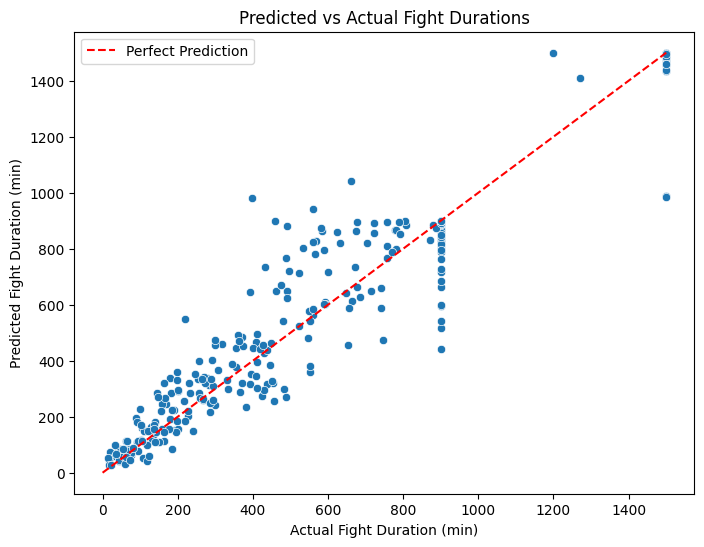

In [287]:
# Predict on test set
y_test_pred = model.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Fight Duration (min)")
plt.ylabel("Predicted Fight Duration (min)")
plt.title("Predicted vs Actual Fight Durations")
plt.legend()
plt.show()


In [288]:
# Predicted mean for a fight in seconds
pred_mean = model.predict(new_fight)[0]

# Residual std from training set (seconds)
y_train_pred = model.predict(X_train)
residual_std = np.std(y_train - y_train_pred)


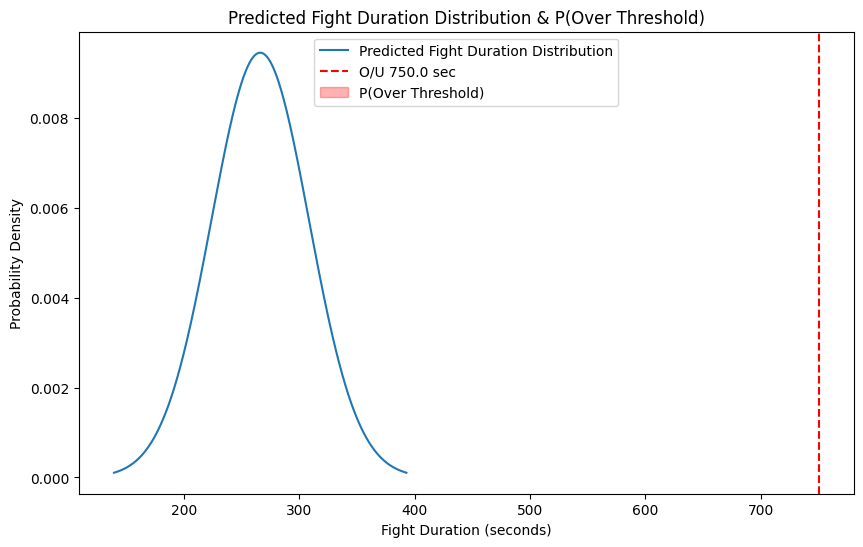

In [289]:
# Define seconds for plotting (±3 std devs around prediction)
x = np.linspace(pred_mean - 3*residual_std,
                pred_mean + 3*residual_std, 500)

# PDF of predicted fight duration
y_pdf = norm.pdf(x, loc=pred_mean, scale=residual_std)

# Example threshold (e.g., 12.5 minutes → 750 seconds)
rounds_per_rounds = 300  # threshold in seconds
rounds = 2.5
threshold_sec = rounds * rounds_per_rounds

plt.figure(figsize=(10,6))
plt.plot(x, y_pdf, label='Predicted Fight Duration Distribution')
plt.axvline(x=threshold_sec, color='r', linestyle='--', label=f'O/U {threshold_sec} sec')

# Shade area over threshold
plt.fill_between(x, 0, y_pdf, where=(x>threshold_sec), color='red', alpha=0.3, label='P(Over Threshold)')

plt.xlabel("Fight Duration (seconds)")
plt.ylabel("Probability Density")
plt.title("Predicted Fight Duration Distribution & P(Over Threshold)")
plt.legend()
plt.show()


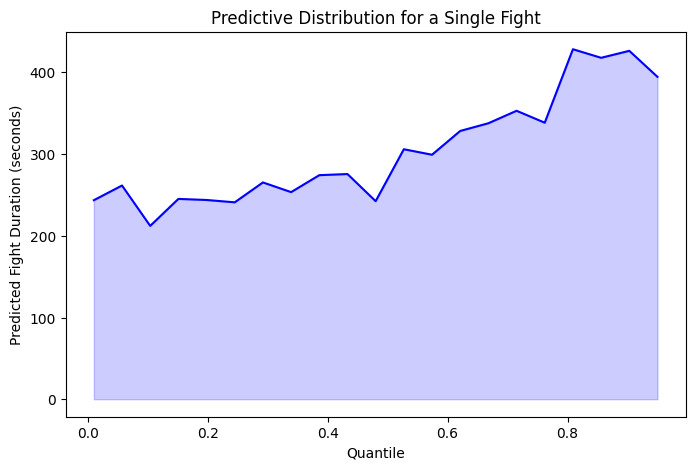

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor

# Suppose model is already trained on X_train, y_train
# new_fight should be a 2D array: shape (1, n_features)
# Example: new_fight = X_test.iloc[[0]]  if using pandas

# Create many quantiles for a smooth distribution
quantile_levels = np.linspace(0.01, 0.95, 21)
predictions = []

for q in quantile_levels:
    model = HistGradientBoostingRegressor(loss='quantile', quantile=q, max_iter=200)
    model.fit(X_train, y_train)
    pred = model.predict(new_fight)
    predictions.append(pred[0])  # single value

predictions = np.array(predictions)

# Plot predictive distribution
plt.figure(figsize=(8,5))
plt.plot(quantile_levels, predictions, color='blue')
plt.fill_between(quantile_levels, predictions, alpha=0.2, color='blue')
plt.xlabel('Quantile')
plt.ylabel('Predicted Fight Duration (seconds)')
plt.title('Predictive Distribution for a Single Fight')
plt.show()


In [242]:
from scipy.interpolate import interp1d
cdf_func = interp1d(predictions, quantile_levels, bounds_error=False, fill_value=(0,1))

# 3️⃣ Compute P(fight duration > T)
sec_per_rounds = 300  # threshold in seconds
rounds = 1.5
T = sec_per_rounds * rounds
P_over_T = 1 - cdf_func(T)
print(f"Probability fight lasts longer than {T} seconds: {P_over_T:.2%}")

Probability fight lasts longer than 450.0 seconds: 0.00%


In [191]:
def american_odds_to_prob(odds):
    """
    Convert American odds to implied probability.
    
    Parameters:
    - odds: int or float, positive (e.g., +120) or negative (e.g., -220)
    
    Returns:
    - probability: float, in [0, 1]
    """
    if odds > 0:
        # Positive odds: profit per $100 stake
        prob = 100 / (odds + 100)
    elif odds < 0:
        # Negative odds: amount you must stake to win $100
        prob = -odds / (-odds + 100)
    else:
        raise ValueError("Odds cannot be zero")
    
    return prob


In [222]:
print(american_odds_to_prob(-230))

0.696969696969697


In [226]:
new_fight = create_new_test_fight(df, "Carlos Ulberg", "Dominick Reyes", 5, fighter_id_map)
new_fight

,fight_format,f1_knockdown,f2_knockdown,f1_sig_strike_land,f2_sig_strike_land,f1_sig_strike_att,f2_sig_strike_att,f1_total_strike_land,f2_total_strike_land,f1_total_strike_att,...,f1_sub_att,f2_sub_att,f1_reversal,f2_reversal,f1_control_time,f2_control_time,fighter1_id,fighter2_id,fighter1_past3,fighter2_past3
0,5,0.833333,0.5,32.666667,27.25,56.666667,51.0,35.166667,28.5,59.333333,...,0.166667,0.25,0.0,0.0,32.5,8.0,335,41,3,-1


In [279]:
from datetime import datetime, timedelta
import pandas as pd

def average_fighting_stats_per_round(df, fighter_id):
    """
    Compute average fighting statistics per round over the last 3 years
    for a given fighter, using both fighter1 and fighter2 columns.
    """
    # Filter fights in last 3 years
    three_years_ago = pd.to_datetime(datetime.now() - timedelta(days=3*365))
    filtered_data = df[((df['fighter1_id'] == fighter_id) | (df['fighter2_id'] == fighter_id)) & (df['date'] >= three_years_ago)]
    
    if len(filtered_data) == 0:
        return {}  # No fights, return empty dict
    
    # Stats to compute
    stats = [
        'knockdown', 'sig_strike_land', 'sig_strike_att',
        'total_strike_land', 'total_strike_att',
        'takedown_land', 'takedown_att',
        'sub_att', 'reversal', 'control_time'
    ]
    
    averages = {}
    
    for stat in stats:
        stat_sum = 0
        total_rounds = 0
        
        # Sum for fighter as fighter1
        f1_mask = filtered_data['fighter1_id'] == fighter_id
        stat_sum += (filtered_data.loc[f1_mask, f"f1_{stat}"] / filtered_data.loc[f1_mask, 'fight_format']).sum()
        total_rounds += f1_mask.sum()
        
        # Sum for fighter as fighter2
        f2_mask = filtered_data['fighter2_id'] == fighter_id
        stat_sum += (filtered_data.loc[f2_mask, f"f2_{stat}"] / filtered_data.loc[f2_mask, 'fight_format']).sum()
        total_rounds += f2_mask.sum()
        
        # Compute average per round
        averages[f"_{stat}"] = stat_sum / total_rounds if total_rounds > 0 else 0
    
    return averages


In [311]:
def average_fighting_stats_per_second(df, fighter_id):
    """
    Compute average fighting statistics per second over the last 3 years
    for a given fighter.
    """
    three_years_ago = pd.to_datetime(datetime.now() - timedelta(days=3*365))
    filtered_data = df[
        ((df['fighter1_id'] == fighter_id) | (df['fighter2_id'] == fighter_id))
        & (df['date'] >= three_years_ago)
    ]
    
    if len(filtered_data) == 0:
        return {}
    
    stats = [
        'knockdown', 'sig_strike_land', 'sig_strike_att',
        'total_strike_land', 'total_strike_att',
        'takedown_land', 'takedown_att',
        'sub_att', 'reversal', 'control_time'
    ]
    
    averages = {}
    
    for stat in stats:
        # Fighter as fighter1
        f1_mask = filtered_data['fighter1_id'] == fighter_id
        f1_vals = filtered_data.loc[f1_mask, f"f1_{stat}"]
        f1_secs = filtered_data.loc[f1_mask, 'fight_duration']
        
        # Fighter as fighter2
        f2_mask = filtered_data['fighter2_id'] == fighter_id
        f2_vals = filtered_data.loc[f2_mask, f"f2_{stat}"]
        f2_secs = filtered_data.loc[f2_mask, 'fight_duration']
        
        per_sec_total = (f1_vals / f1_secs).sum() + (f2_vals / f2_secs).sum()
        total_fights = f1_mask.sum() + f2_mask.sum()
        
        averages[f"_{stat}_per_sec"] = per_sec_total / total_fights if total_fights > 0 else 0
    
    return averages